# business Problem

#### Objetivo do Problema
    -- Previsão do primeiro destino que um novo usuario irá escolher.

#### Porque?
**Qual tipo de modelo de negócio do AirBNB?**
    
    -- MarketPlace (Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

    -- Tamanho do portfolio
    -- Diversidade/densidade de portfolio
    -- Preço medio

##### Demanda (Pessoas procurando acomodação)

    -- Numero de usuarios
    -- LTV (Lifitime Value)
    -- CAC (Client Acquisition Cost)

**Cross Revenue** (FEE * Numero Cliente) - CAC

#### Proposta da Solução

    -- Modelo de predição do primeiro destino de um novo usuario.

##### Tipos de formatos para entrega do projeto.
    -- Predições salva em tabela do banco de dados.
    -- API: Input: Usuario e suas caracteristicas / Output: Usuario e suas caracteristicas com as Predições do destino.

# Ciclo07: Feature Selection

# 00 - Imports

In [2]:
import pandas as pd
import random
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder

from keras import models as ml
from keras import layers as l

import warnings
import pickle

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML(""))

2022-12-16 22:34:10.402284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 22:34:10.487462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-16 22:34:10.487474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 22:34:10.507249: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 22:34:10.998179: W tensorflow/stream_executor/platform/de

## Functions

In [3]:
def drescriptive_statistical (df):

    num_atributes = df.copy()
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(num_atributes.apply(np.std)).T
    d2 = pd.DataFrame(num_atributes.apply(min)).T
    d3 = pd.DataFrame(num_atributes.apply(max)).T
    d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()


#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

## Paths

In [5]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/models/'
path_transformation = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/transformation_data/'

## Loading Data

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever


# 8.0 Feature Selection

In [38]:
data = pd.read_csv(path_data+'ciclo006_feature_selection_dataset.csv')

data.head()

,affiliate_channel,first_affiliate_tracked,age,signup_flow,days_from _first_active_until_account_created,days_from _account_created_until_booking,date_account_created_year,timestamp_first_active_year,date_first_booking_year,date_account_created_month,...,date_first_booking_week_sin,date_first_booking_week_cos,date_account_created_day_sin,date_account_created_day_cos,date_account_created_week_sin,date_account_created_week_cos,timestamp_first_active_week_sin,timestamp_first_active_week_cos,timestamp_first_active_day_sin,timestamp_first_active_day_cos
0,5.268086,5.280842,0.801870,0.0,0.578705,28.468750,0.00,0.600000,1.0,0.454545,...,0.000000,1.000000,-0.571268,0.820763,0.000000,1.000000,0.781831,0.623490,0.571268,0.820763
1,5.131527,5.280842,-0.158925,0.0,0.868441,23.296875,0.25,0.733333,1.0,0.363636,...,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521,0.781831,0.623490,0.848644,0.528964
2,5.268086,5.280842,1.413285,3.0,-0.279754,-0.078125,0.00,0.266667,0.0,0.727273,...,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490,-0.781831,0.623490,0.937752,0.347305
3,5.268086,5.280842,0.190455,0.0,1.567955,4.265625,0.25,1.000000,0.4,1.000000,...,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000,0.974928,-0.222521,0.897805,-0.440394
4,5.268086,5.280842,0.103110,0.0,-0.279754,-0.078125,0.00,0.233333,0.0,0.727273,...,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490,-0.433884,-0.900969,0.651372,-0.758758


In [39]:
X = data.drop('country_destination', axis=1)
y = data['country_destination'].copy()

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)

### Find important features with Random Forest Model

In [11]:
# import random forest

from sklearn.ensemble import RandomForestClassifier

# Instantiate the Classifier

rfc = RandomForestClassifier (random_state= 0)

#fit the model

rfc.fit(X_train, y_train)

#View the feature Score

feature_score = pd.Series(rfc.feature_importances_, index= X_train.columns).sort_values(ascending=False)

feature_score

days_from _account_created_until_booking         0.100960
age                                              0.080955
date_first_booking_day                           0.077617
first_affiliate_tracked                          0.046305
affiliate_channel                                0.041042
date_first_booking_month                         0.039093
date_account_created_day_sin                     0.037540
date_first_booking_week                          0.036467
date_account_created_day                         0.035751
timestamp_first_active_year                      0.035694
date_account_created_day_cos                     0.033997
days_from _first_active_until_account_created    0.032827
date_first_booking_year                          0.032428
date_first_booking_week_sin                      0.029038
date_first_booking_week_cos                      0.027189
date_account_created_month                       0.027045
timestamp_first_active_week                      0.025910
date_account_c

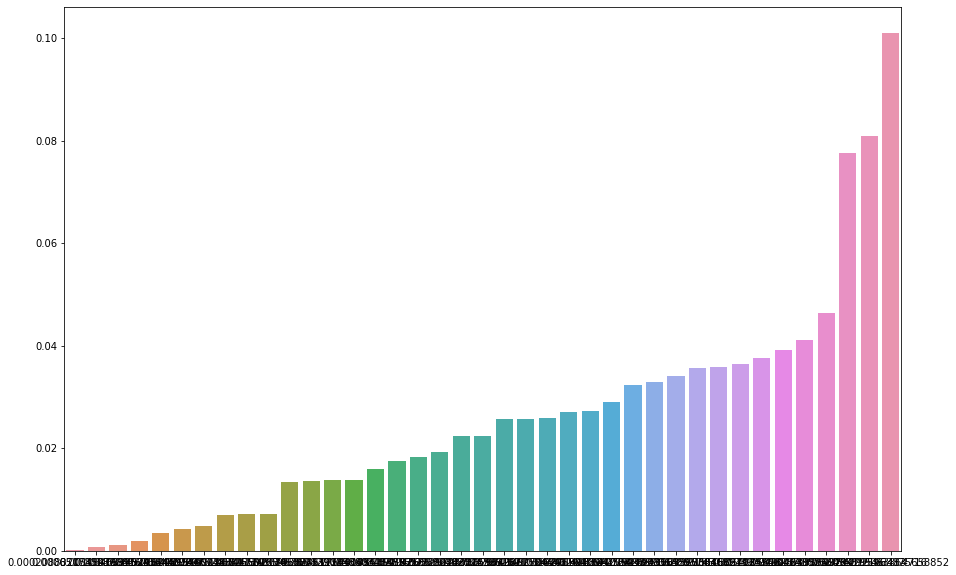

In [22]:
ax = plt.subplots(figsize=(15, 10))
sns.barplot(x= feature_score, y= feature_score.index, data=feature_score)
plt.show()

### Find Boruta

In [27]:
#Define Model
#rfc = RandomForestClassifier (random_state= 0, n_jobs=-1)

#Training and test dataset for Boruta (Does not accept dataframe, turn into numpy)

#X_train_b = X_train.values
#y_train_b = y_train.values

#Define Boruta
#from boruta import BorutaPy

#boruta = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=42,).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	39
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	4
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	25
Tentative: 	4
Reject

### Beast Features From Boruta

In [29]:
#cols_select = boruta.support_.tolist()

In [30]:
#X_train_fs = X_train

#cols_select_boruta = X_train_fs.iloc[:, cols_select].columns.to_list() #Features selecionada pelo modelo

#cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_select_boruta)) #Feature que o boruta rejeitor

In [41]:
cols_selected_boruta = [
 'affiliate_channel',
 'first_affiliate_tracked',
 'age',
 'signup_flow',
 'days_from _first_active_until_account_created',
 'days_from _account_created_until_booking',
 'timestamp_first_active_year',
 'date_first_booking_year',
 'date_account_created_month',
 'timestamp_first_active_month',
 'date_first_booking_month',
 'date_account_created_week',
 'timestamp_first_active_week',
 'date_first_booking_week',
 'date_account_created_day',
 'date_first_booking_day',
 'gender_FEMALE',
 'signup_method_facebook',
 'date_first_booking_week_sin',
 'date_first_booking_week_cos',
 'date_account_created_day_sin',
 'date_account_created_day_cos',
 'date_account_created_week_sin',
 'date_account_created_week_cos',
 'timestamp_first_active_week_sin',
 'timestamp_first_active_week_cos']



In [53]:
X_train = X_train[cols_select_boruta]
X_train.to_csv(path_data+'X_train_cols_select.csv', index=False)

X_val = X_val[cols_select_boruta]
X_val.to_csv(path_data+'X_val_cols_select.csv', index=False)

y_train.to_csv(path_data+'y_train.csv', index=False)

y_val.to_csv(path_data+'y_val.csv', index=False)


In [44]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1)).toarray()

# 9.0 Machine Learning Model

### Baseline Model

In [46]:
country_destination_list = data['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_val.shape[0]
country_destination_weights = data['country_destination'].value_counts( normalize=True).sort_index().tolist()

#Modelo Aleatório
yhat_random = random.choices( population=country_destination_list, k=k_num, weights=country_destination_weights)

Accuracy: 0.08371148414939866
Balanced Accuracy: 0.08293105218345503
Kappa Score: -0.00036229992906400277


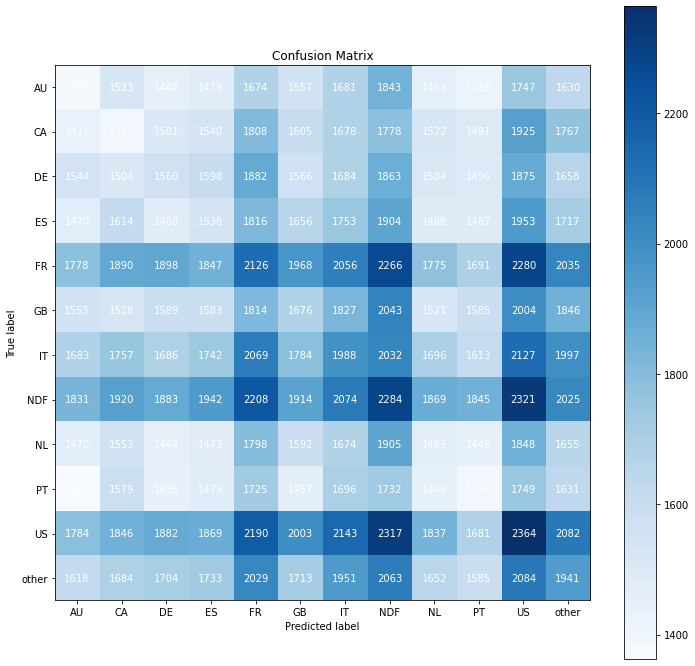

In [47]:
#Accuracy
acc_random = m.accuracy_score(y_val, yhat_random)
print('Accuracy: {}'.format(acc_random))

#Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_random, normalize= False, figsize=(12,12))

#Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score(y_val, yhat_random )
print('Balanced Accuracy: {}'.format(balanced_accuracy_random))

#Kappa Metrics
kappa_score_random = m.cohen_kappa_score(y_val, yhat_random)
print('Kappa Score: {}'.format(kappa_score_random))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))

### Neural Network MLP

In [48]:
##Model Definition
model = ml.Sequential()
#
model.add( l.Dense(128, input_dim=X_train.shape[1], activation= 'relu'))
model.add( l.Dense( 12, activation = 'softmax'))
#
#model Compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit( X_train, y_train_nn, epochs=100)

2022-12-17 08:50:37.176050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 08:50:37.176216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 08:50:37.176257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-17 08:50:37.176292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-17 08:50:37.176327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/100
31513/31513 [==============================] - 18s 551us/step - loss: 2.0449 - accuracy: 0.2684
Epoch 2/100
31513/31513 [==============================] - 18s 559us/step - loss: 1.9401 - accuracy: 0.3105
Epoch 3/100
31513/31513 [==============================] - 18s 573us/step - loss: 1.9045 - accuracy: 0.3228
Epoch 4/100
31513/31513 [==============================] - 18s 568us/step - loss: 1.8863 - accuracy: 0.3292
Epoch 5/100
31513/31513 [==============================] - 18s 556us/step - loss: 1.8742 - accuracy: 0.3339
Epoch 6/100
31513/31513 [==============================] - 17s 555us/step - loss: 1.8656 - accuracy: 0.3374
Epoch 7/100
31513/31513 [==============================] - 17s 552us/step - loss: 1.8584 - accuracy: 0.3396
Epoch 8/100
31513/31513 [==============================] - 17s 552us/step - loss: 1.8531 - accuracy: 0.3417
Epoch 9/100
31513/31513 [==============================] - 17s 553us/step - loss: 1.8486 - accuracy: 0.3430
Epoch 10/100
31513/31513 [==

In [49]:
#Salvando o treinamento em um arquico compactado
pickle.dump(model, open(path_model+'ciclo007_feature_select_boruta_model_NLP.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://6c14b572-28e0-4d2d-912c-3b816374c961/assets


In [50]:
model = pickle.load(open(path_model+'ciclo007_feature_select_boruta_model_NLP.pkl', 'rb'))

#Prediction
pred_nn = model.predict(X_val)

#Invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#Prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

7879/7879 [==============================] - 3s 435us/step


Accuracy: 0.36634087519436426
Balanced Accuracy: 0.36500792894874645
Kappa Score: 0.30832255569348554


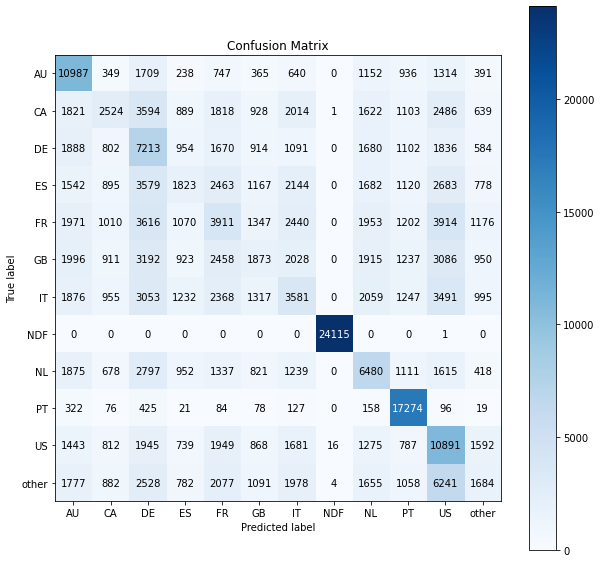

In [51]:
#Accuracy
acc_nn = m.accuracy_score(y_val_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Confusion Matrix
mt.plot_confusion_matrix( y_val_nn, yhat_nn, normalize= False, figsize=(10,10))

#Balanced Accuracy
balanced_accuracy = m.balanced_accuracy_score(y_val_nn, yhat_nn )
print('Balanced Accuracy: {}'.format(balanced_accuracy))

#Kappa Metrics
kappa_score = m.cohen_kappa_score(y_val_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))